In [26]:
import requests
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obtener lista de países y territorios del Banco Mundial
resp = requests.get("https://api.worldbank.org/v2/country", params={"format": "json", "per_page": 400})
data = resp.json()
paises = data[1]

# Crear tabla con datos básicos de cada país (DataFrame)
df_countries = pd.DataFrame([
    {
        "name": p["name"],
        "iso3Code": p["id"],
        "region": p["region"]["value"],
        "adminregion": p["adminregion"]["value"]
    }
    for p in paises
])

# Filtro para quitar agregados ( adminregion = "" )
#df_countries = df_countries[df_countries["adminregion"] != ""].reset_index(drop=True)
df_countries = df_countries[df_countries["region"] != "Aggregates"].reset_index(drop=True)

# *************************************
# **********  IMPORTANTE *************
# *************************************
# Comenta y descomenta según convenga para descargar el .csv

# descargar = True
descargar = False


# Usamos función para encapsular toda la lógica de descarga,
# pero ahora descargamos TODOS los países a la vez para cada indicador
# (muchísimo más rápido que hacerlo país por país)
def logica_descarga(indicator_code, start_year=1980, end_year=2023):
    
    # URL para sacar TODA la serie del indicador para TODOS los países
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator_code}"

    # Pedimos todo en una sola página (per_page alto)
    params = {
        "format": "json",
        "per_page": 20000,
        "date": f"{start_year}:{end_year}"
    }

    # Hacemos la petición a la API
    resp = requests.get(url, params=params)
    
    # Respuesta en JSON
    data = resp.json()

    # Convertimos la lista a diccionario (iso3, año) -> valor
    # para acceder muy rápido después
    series = {}
    for entry in data[1]:
        iso3 = entry["countryiso3code"]
        year = entry["date"]
        value = entry["value"]
        series[(iso3, year)] = value
    
    return series


if descargar:
    # Los códigos que necesitamos
    esperanza_vida = "SP.DYN.LE00.IN"
    pib = "NY.GDP.PCAP.CD"

    print("Descargando series de todos los países...")

    # >>> Aquí hacemos solo DOS peticiones: una por indicador
    esperanza_series = logica_descarga(esperanza_vida)
    pib_series = logica_descarga(pib)

    print("Descarga completada.")

    # Creamos el CSV donde guardaremos la tabla completa
    with open("data/datos.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["country", "iso3", "region", "year", "life_expectancy", "gdp_per_capita"])
        
        # Recorremos cada país de nuestro DataFrame original
        for i, row in df_countries.iterrows():
            iso3 = row["iso3Code"]
            name = row["name"]
            region = row["region"]

            print(f"Escribiendo datos de {name}")

            # Recorremos cada año y hacemos una fila por año
            for year in range(1980, 2023 + 1):
                y = str(year)

                # Obtenemos los valores ya guardados en los diccionarios
                life = esperanza_series.get((iso3, y))
                gdp = pib_series.get((iso3, y))

                writer.writerow([name, iso3, region, y, life, gdp])

else:
    print("Comprueba, si sale error no la tienes descargada, cambia a descargar = True")


# Cargamos el CSV generado
df = pd.read_csv("data/datos.csv")
df.head()

Comprueba, si sale error no la tienes descargada, cambia a descargar = True


,country,iso3,region,year,life_expectancy,gdp_per_capita
0,Aruba,ABW,Latin America & Caribbean,1980,70.771,NaN
1,Aruba,ABW,Latin America & Caribbean,1981,71.344,NaN
2,Aruba,ABW,Latin America & Caribbean,1982,71.485,NaN
3,Aruba,ABW,Latin America & Caribbean,1983,71.606,NaN
4,Aruba,ABW,Latin America & Caribbean,1984,71.711,NaN


In [2]:
df_life = df.copy()

In [3]:
df = df.dropna(subset=["gdp_per_capita"]) # Aqui cambiamos los flitros y solo coge los que tenga pregntas referente al pib por ejemplo, en las de EVA no las podemos utilizar

# Países con mayor y menor PIB per cápita

In [4]:
ultimo_año = df['year'].max()

In [5]:
df_ultimo = df[df['year'] == ultimo_año]

In [6]:
ranking_paises_pib = (
                       df_ultimo[['country', 'gdp_per_capita']]
                       .sort_values('gdp_per_capita', ascending=False))

In [7]:
top_10_pib = ranking_paises_pib.head(10).reset_index(drop=True)
top_10_pib

,country,gdp_per_capita
0,Monaco,256799.788613
1,Liechtenstein,206780.590353
2,Luxembourg,133230.619179
3,Bermuda,132604.439086
4,Ireland,106818.917131
5,Switzerland,100623.549627
6,Cayman Islands,99143.518024
7,Norway,87497.217965
8,Singapore,85412.230345
9,Iceland,82138.789297


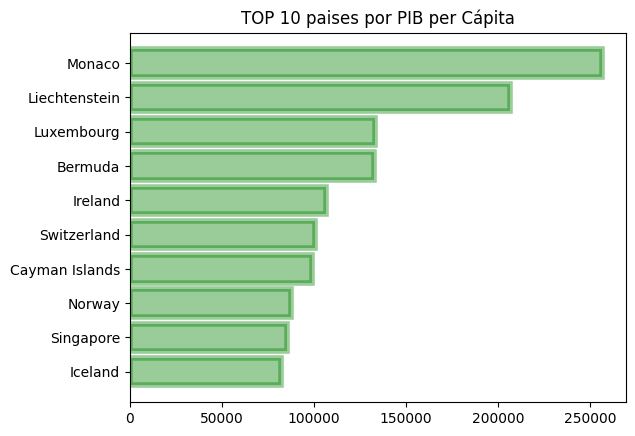

In [8]:
plt.barh(
    data=top_10_pib,
    y="country",
    width="gdp_per_capita",
    color='green',
    align = "center",
    edgecolor = "green",
    linewidth = 4,
    alpha=0.4
)
plt.title(f"TOP 10 paises por PIB per Cápita")
plt.gca().invert_yaxis()

El gráfico muestra los 10 países con mayor PIB per cápita en el último año disponible. Mónaco y Liechtenstein destacan claramente por encima del resto, con valores muy superiores a la media, seguidos por economías pequeñas y altamente desarrolladas como Luxemburgo, Irlanda y Suiza. El resultado refleja una alta concentración de renta en países de tamaño reducido y elevada especialización económica.

In [9]:
last_10_pib = ranking_paises_pib.tail(10).sort_values(by='gdp_per_capita').reset_index(drop=True)
last_10_pib

,country,gdp_per_capita
0,Burundi,250.627253
1,Afghanistan,413.757895
2,Central African Republic,495.978897
3,Madagascar,508.718428
4,"Somalia, Fed. Rep.",596.885985
5,Mozambique,622.000298
6,Malawi,633.214768
7,Niger,638.336081
8,"Congo, Dem. Rep.",660.212052
9,Sierra Leone,758.329137


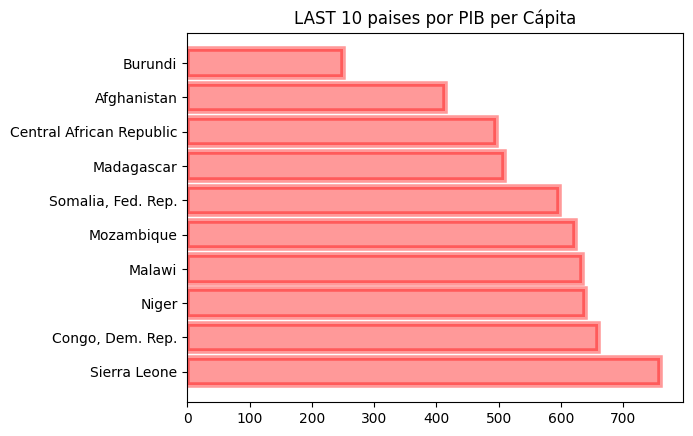

In [10]:
plt.barh(
    data=last_10_pib,
    y="country",
    width="gdp_per_capita",
    color='red',
    align = "center",
    edgecolor = "red",
    linewidth = 4,
    alpha=0.4
)
plt.title(f"LAST 10 paises por PIB per Cápita")
plt.gca().invert_yaxis()

El gráfico muestra los 10 países con menor PIB per cápita en el último año disponible. Burundi y Afganistán presentan los valores más bajos, mientras que Sierra Leona, aunque lidera este grupo, mantiene un nivel de renta muy reducido. En conjunto, el gráfico refleja situaciones de elevada vulnerabilidad económica, concentradas principalmente en países africanos.

# Países con mayor y menor esperanza de vida

In [11]:
df_life_media = (
    df_life.groupby(["country", "region"])["life_expectancy"]
    .mean()
    .reset_index()
    .rename(columns={
        "country": "pais",
        "life_expectancy": "esperanza_vida_media"
    })
)

df_life_media.head()

,pais,region,esperanza_vida_media
0,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",53.090205
1,Albania,Europe & Central Asia,75.267068
2,Algeria,"Middle East, North Africa, Afghanistan & Pakistan",70.072114
3,American Samoa,East Asia & Pacific,71.715750
4,Andorra,Europe & Central Asia,81.523409


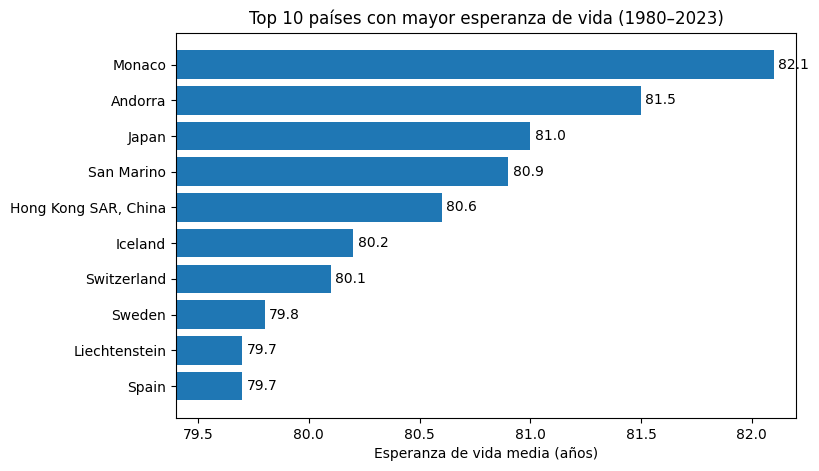

In [12]:
top_10_esperanza = df_life_media.sort_values("esperanza_vida_media", ascending=False).head(10)
top_10_esperanza["esperanza_vida_media"] = top_10_esperanza["esperanza_vida_media"].round(1)

xmin = top_10_esperanza["esperanza_vida_media"].min() - 0.3
xmax = top_10_esperanza["esperanza_vida_media"].max() + 0.1

plt.figure(figsize=(8,5))
bars = plt.barh(data=top_10_esperanza, y="pais", width="esperanza_vida_media")

for bar in bars:
    plt.text(bar.get_width() + 0.02,
             bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}", va="center")

plt.xlim(xmin, xmax)
plt.xlabel("Esperanza de vida media (años)")
plt.title("Top 10 países con mayor esperanza de vida (1980–2023)")
plt.gca().invert_yaxis()
plt.show()

El gráfico presenta los 10 países con mayor esperanza de vida media en el periodo 1980–2023. Mónaco lidera claramente el ranking, seguido por países europeos y asiáticos como Andorra, San Marino y Japón, todos con valores superiores a los 80 años. En conjunto, los resultados reflejan altos niveles de desarrollo sanitario y calidad de vida en estas economías avanzadas.

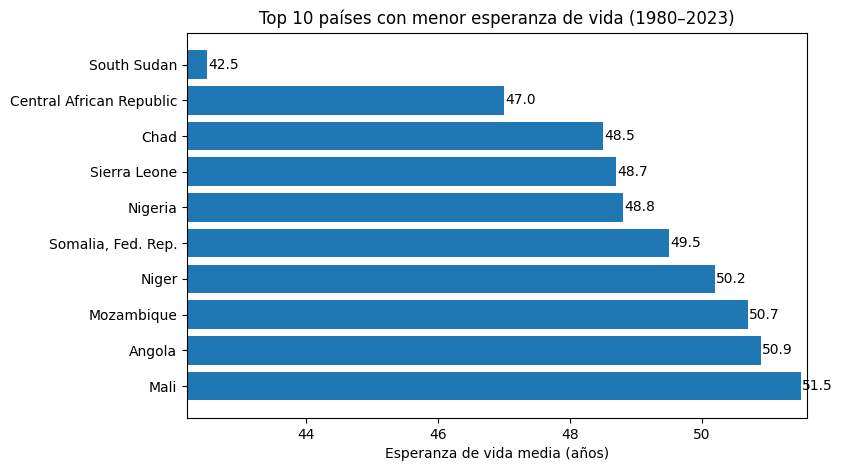

In [13]:
last_10_esperanza = df_life_media.sort_values("esperanza_vida_media", ascending=True).head(10).reset_index(drop=True)
last_10_esperanza["esperanza_vida_media"] = last_10_esperanza["esperanza_vida_media"].round(1)

xmin = last_10_esperanza["esperanza_vida_media"].min() - 0.3
xmax = last_10_esperanza["esperanza_vida_media"].max() + 0.1

plt.figure(figsize=(8,5))
bars = plt.barh(data=last_10_esperanza, y="pais", width="esperanza_vida_media")

for bar in bars:
    plt.text(bar.get_width() + 0.02,
             bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}", va="center")

plt.xlim(xmin, xmax)
plt.xlabel("Esperanza de vida media (años)")
plt.title("Top 10 países con menor esperanza de vida (1980–2023)")
plt.gca().invert_yaxis()
plt.show()

El gráfico muestra los 10 países con menor esperanza de vida media en el periodo 1980–2023. República Centroafricana presenta el valor más bajo, seguida de países como Lesoto y Chad, con esperanzas de vida en torno a los 50 años. En conjunto, el gráfico refleja graves desigualdades en salud y condiciones de vida, concentradas principalmente en países africanos.

# ¿Coinciden los países más ricos con los de mayor esperanza de vida?

TOP 10 países más ricos en 2023:
          country iso3  gdp_per_capita
0          Monaco  MCO   256799.788613
1   Liechtenstein  LIE   206780.590353
2      Luxembourg  LUX   133230.619179
3         Bermuda  BMU   132604.439086
4         Ireland  IRL   106818.917131
5     Switzerland  CHE   100623.549627
6  Cayman Islands  CYM    99143.518024
7          Norway  NOR    87497.217965
8       Singapore  SGP    85412.230345
9         Iceland  ISL    82138.789297


TOP 10 países con mayor esperanza de vida en 2023:
                country iso3  life_expectancy
0                Monaco  MCO        86.372000
1            San Marino  SMR        85.706000
2  Hong Kong SAR, China  HKG        85.247317
3         Liechtenstein  LIE        84.841463
4      French Polynesia  PYF        84.070000
5           Switzerland  CHE        84.056098
6                 Japan  JPN        84.041220
7               Andorra  AND        84.041000
8                 Spain  ESP        83.882927
9                 Italy  

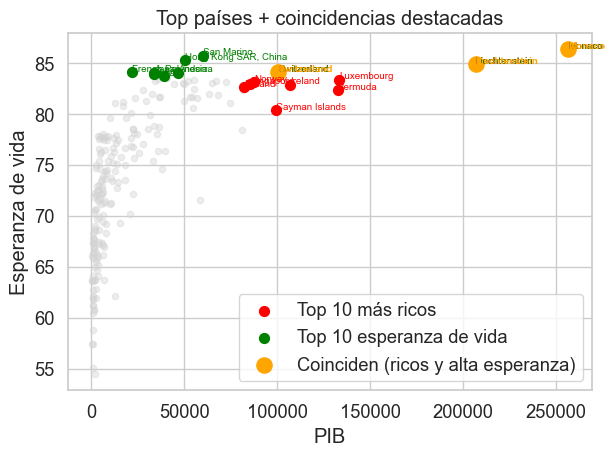

In [65]:
df_2023 = df[df["year"] == 2023]

top_ricos = df_2023.sort_values("gdp_per_capita", ascending=False).head(10).reset_index(drop=True)
top_vida = df_2023.sort_values("life_expectancy", ascending=False).head(10).reset_index(drop=True)

print("TOP 10 países más ricos en 2023:")
print(top_ricos[["country", "iso3", "gdp_per_capita"]])

print("\n")

print("TOP 10 países con mayor esperanza de vida en 2023:")
print(top_vida[["country", "iso3", "life_expectancy"]])

print("\n")

coinciden = set(top_ricos["country"]) & set(top_vida["country"])
porcentaje = (len(coinciden)/ len(df_2023)*100)

print(f"Los pasises mas ricos con mayor esperanza de vida son {coinciden} Esto representa el {porcentaje:.2f}% detodos los paises analizados.")

print("\n")

coinc = df_2023[df_2023["country"].isin(coinciden)]
plt.scatter(df_2023["gdp_per_capita"], df_2023["life_expectancy"],
            color="lightgray", alpha=0.4, s=20)

# Top ricos
plt.scatter(top_ricos["gdp_per_capita"], top_ricos["life_expectancy"],
            color="red", s=50, label="Top 10 más ricos")

# Top vida
plt.scatter(top_vida["gdp_per_capita"], top_vida["life_expectancy"],
            color="green", s=50, label="Top 10 esperanza de vida")

# COINCIDENTES EN NARANJA
plt.scatter(coinc["gdp_per_capita"], coinc["life_expectancy"],
            color="orange", s=120, label="Coinciden (ricos y alta esperanza)")

# Etiquetas
for _, row in top_ricos.iterrows():
    plt.text(row["gdp_per_capita"], row["life_expectancy"]+0.1,
             row["country"], fontsize=7, color="red")

for _, row in top_vida.iterrows():
    plt.text(row["gdp_per_capita"], row["life_expectancy"]+0.1,
             row["country"], fontsize=7, color="green")

for _, row in coinc.iterrows():
    plt.text(row["gdp_per_capita"], row["life_expectancy"]+0.1,
             row["country"], fontsize=7, color="orange", weight="bold")

plt.xlabel("PIB")
plt.ylabel("Esperanza de vida")
plt.title("Top países + coincidencias destacadas")
plt.legend()
plt.tight_layout()
plt.show()


# Evolución de la Riqueza Mundial (2000-2023)

In [16]:
df_2000_2023 = df[df["year"] >= 2000].copy() 

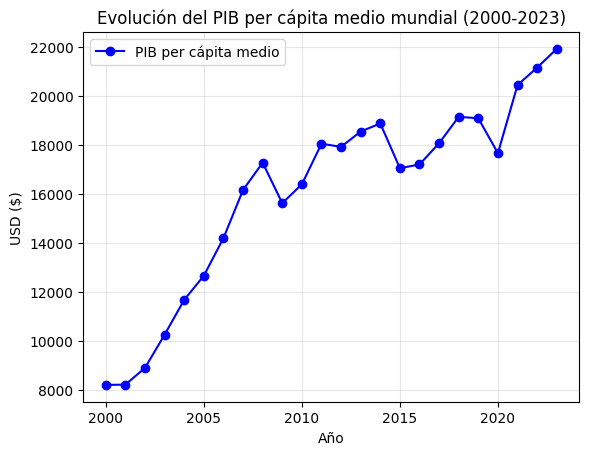

In [17]:
pib_anual = df_2000_2023.groupby("year")["gdp_per_capita"].mean()

# Gráfico de líneas para mostrar la tendencia histórica

plt.plot(pib_anual.index, pib_anual.values, marker='o', color='blue', linestyle='-', label='PIB per cápita medio')

plt.title("Evolución del PIB per cápita medio mundial (2000-2023)")
plt.xlabel("Año")
plt.ylabel("USD ($)")
plt.grid(True, alpha=0.3) 
plt.legend()

Como se observa en la gráfica, el PIB per cápita medio mundial ha experimentado un crecimiento notable, pasando de aproximadamente 1.500 USD en el año 2000 a cerca de 5.000 USD en 2023. A pesar de esta tendencia ascendente, son claramente visibles los retrocesos económicos globales de 2009 (crisis financiera) y 2020 (pandemia), lo que demuestra la vulnerabilidad de la riqueza media ante eventos mundiales. No obstante, la recuperación posterior a estas crisis ha sido rápida, manteniendo la trayectoria de crecimiento en este siglo.

# Distribución del PIB per cápita medio por regiones

In [18]:
#Media de PIB por región
gdp_region = (
    df.groupby('region')['gdp_per_capita']
        .mean()
        .reset_index()
        .sort_values('gdp_per_capita', ascending=False)
        .reset_index(drop=True))
gdp_region

,region,gdp_per_capita
0,North America,45810.627702
1,Europe & Central Asia,24584.663425
2,"Middle East, North Africa, Afghanistan & Pakistan",10753.835726
3,East Asia & Pacific,10532.703257
4,Latin America & Caribbean,8550.976554
5,South Asia,1649.591041
6,Sub-Saharan Africa,1527.770519


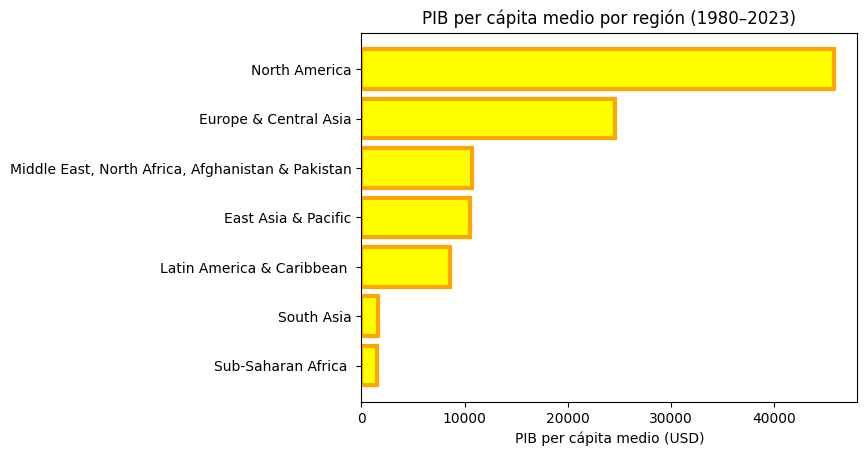

In [19]:
#Gráfico comparativo por region
plt.barh(
    data=gdp_region,
    y="region",
    width="gdp_per_capita",
    color='yellow',
    align = "center",
    edgecolor = "orange",
    linewidth = 3
)
plt.title("PIB per cápita medio por región (1980–2023)")
plt.xlabel("PIB per cápita medio (USD)")
plt.gca().invert_yaxis()

El gráfico compara el PIB per cápita medio por regiones en el periodo 1980–2023. América del Norte destaca claramente como la región con mayor nivel de renta, seguida por Europa y Asia Central, mientras que África Subsahariana y Asia del Sur presentan los valores más bajos. El resultado evidencia desigualdades económicas estructurales muy marcadas entre regiones del mundo.

In [20]:
#Región con mas PIB promedio y menos PIB promedio

region_max = gdp_region.iloc[0]
region_min = gdp_region.iloc[-1]

region_max, region_min

(region            North America
 gdp_per_capita     45810.627702
 Name: 0, dtype: object,
 region            Sub-Saharan Africa 
 gdp_per_capita            1527.770519
 Name: 6, dtype: object)

# Esperanza de vida media por región

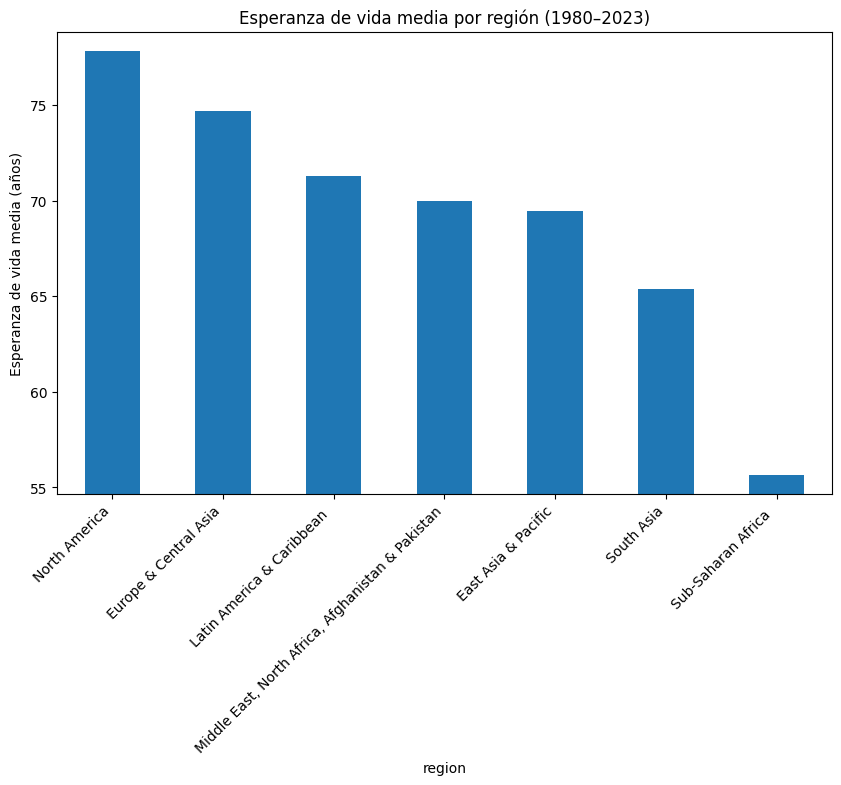

In [21]:
df_final = df_life_media.copy()

region_life_expectancy = (
    df_final.groupby("region")["esperanza_vida_media"]
    .mean()
    .sort_values(ascending=False)
)

xmin = region_life_expectancy.min() - 1
xmax = region_life_expectancy.max() + 1

plt.figure(figsize=(10,6))
region_life_expectancy.plot(kind="bar")
plt.ylim(xmin, xmax)
plt.ylabel("Esperanza de vida media (años)")
plt.title("Esperanza de vida media por región (1980–2023)")
plt.xticks(rotation=45, ha="right")
plt.show()

El gráfico muestra la esperanza de vida media por región en el periodo 1980–2023. América del Norte y Europa–Asia Central presentan los valores más altos, mientras que África Subsahariana se sitúa claramente en el nivel más bajo. En conjunto, el gráfico evidencia desigualdades regionales persistentes en salud y calidad de vida.

# ¿Qué países se comportan de forma atípica respecto a la relación riqueza–bienestar?

In [61]:
# Mediana como referencia
mediana_pib = df_2023["gdp_per_capita"].median()
mediana_vida = df_2023["life_expectancy"].median()

# VALORES ATOPICOS NEGATIVOS
val_ato_neg = df_2023[
    (df_2023["gdp_per_capita"] > mediana_pib) &
    (df_2023["life_expectancy"] < mediana_vida)
][["country", "iso3", "gdp_per_capita", "life_expectancy"]].sort_values("gdp_per_capita", ascending=False).reset_index(drop=True)

# VALORES ATOPICOS POSITIVOS
val_ato_pos = df_2023[
    (df_2023["gdp_per_capita"] < mediana_pib) &
    (df_2023["life_expectancy"] > mediana_vida)
][["country", "iso3", "gdp_per_capita", "life_expectancy"]].sort_values("life_expectancy", ascending=False).reset_index(drop=True)


print("Los valores atípicos de ricos pero con baja esperanza de vida:")
print(val_ato_neg)

print("\n")

print("Los valores atípicos de pobres pero con alta esperanza de vida:")
print(val_ato_pos)

Los valores atípicos de ricos pero con baja esperanza de vida:
                           country iso3  gdp_per_capita  life_expectancy
0                        Greenland  GRL    58498.970797        71.549756
1              St. Kitts and Nevis  KNA    22576.924844        72.145000
2                           Guyana  GUY    20473.700219        70.180000
3              Trinidad and Tobago  TTO    18308.453630        73.490000
4                            Palau  PLW    15610.823193        69.269000
5               Russian Federation  RUS    14159.387695        73.254634
6                        St. Lucia  LCA    13554.768478        72.697000
7                       Kazakhstan  KAZ    12879.427526        74.402000
8                            Nauru  NRU    12752.472386        62.109000
9                        Mauritius  MUS    11269.968446        73.412195
10              Dominican Republic  DOM    10630.431744        73.720000
11  St. Vincent and the Grenadines  VCT    10582.365673      

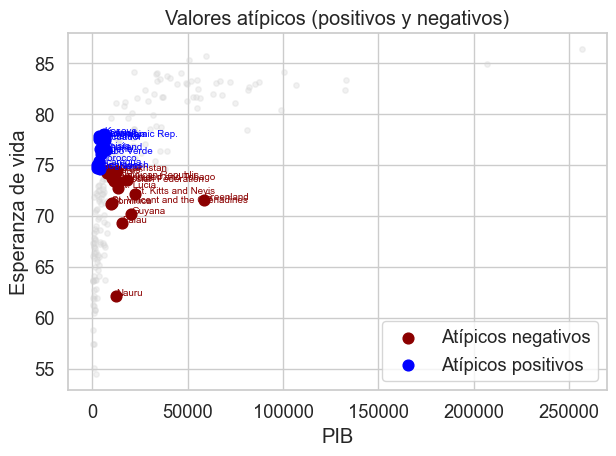

In [64]:


# Resto de países en gris de fondo (suave)
plt.scatter(df_2023["gdp_per_capita"], df_2023["life_expectancy"],
            color="lightgray", alpha=0.3, s=15)

# Atípicos negativos (ricos con baja esperanza)
plt.scatter(val_ato_neg["gdp_per_capita"], val_ato_neg["life_expectancy"],
            color="darkred", s=60, label="Atípicos negativos")

# Atípicos positivos (pobres con alta esperanza)
plt.scatter(val_ato_pos["gdp_per_capita"], val_ato_pos["life_expectancy"],
            color="blue", s=60, label="Atípicos positivos")

# Etiquetas
for i, row in val_ato_neg.iterrows():
    plt.text(row["gdp_per_capita"], row["life_expectancy"] + 0.1,
             row["country"], fontsize=7, color="darkred")

for i, row in val_ato_pos.iterrows():
    plt.text(row["gdp_per_capita"], row["life_expectancy"] + 0.1,
             row["country"], fontsize=7, color="blue")

plt.xlabel("PIB")
plt.ylabel("Esperanza de vida")
plt.title("Valores atípicos (positivos y negativos)")
plt.legend()
plt.tight_layout()
plt.show()


#  El Vínculo entre Riqueza y Bienestar

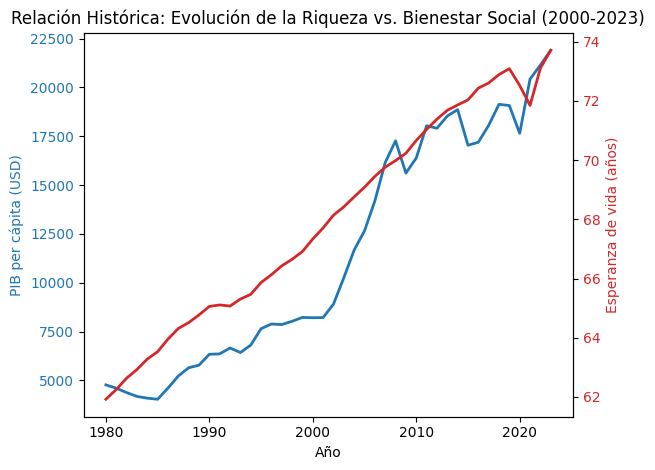

In [24]:
# Calculamos las medias anuales de ambos indicadores simultáneamente
evolucion_total = df.groupby("year")[["gdp_per_capita", "life_expectancy"]].mean()

# VISUALIZACIÓN P8: Gráfico de doble eje (TwinX)
fig, ax1 = plt.subplots()

# Configuración del Eje 1 (Izquierdo - PIB)
ax1.set_xlabel('Año')
ax1.set_ylabel('PIB per cápita (USD)', color='tab:blue')
ax1.plot(evolucion_total.index, evolucion_total['gdp_per_capita'], color='tab:blue', linewidth=2, label='PIB Medio')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Configuración del Eje 2 (Derecho - Esperanza de Vida)
ax2 = ax1.twinx() 
ax2.set_ylabel('Esperanza de vida (años)', color='tab:red')
ax2.plot(evolucion_total.index, evolucion_total['life_expectancy'], color='tab:red', linewidth=2, label='Esperanza Vida')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Título final que resume la narrativa del grupo [11]
plt.title("Relación Histórica: Evolución de la Riqueza vs. Bienestar Social (2000-2023)")
fig.tight_layout() # Ajusta el gráfico para que no se corten las etiquetas


Esta comparativa final permite confirmar que, a largo plazo, la riqueza y el bienestar han evolucionado de forma positiva y conjunta. Mientras que la línea azul (PIB) muestra una mayor volatilidad debido a las crisis económicas, la línea roja (esperanza de vida) presenta un crecimiento más constante y resiliente. Esto sugiere que el desarrollo económico global desde el año 2000 ha servido como motor para mejorar la longevidad humana, logrando que ambos indicadores cierren el periodo en sus puntos más altos de la historia reciente.